# Setup

In [ ]:
!pip install --quiet bitsandbytes evaluate jiwer rouge_score trl

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.7 MB/s eta 0:00:00
ERRO

In [ ]:
import os

import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType
)
from datasets import load_dataset
from evaluate import load
from tqdm import tqdm

import wandb
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

from trl import SFTTrainer, SFTConfig, setup_chat_format
import bitsandbytes as bnb

user_secrets = UserSecretsClient()
login(user_secrets.get_secret("HF_TOKEN"))
wandb.login(key=user_secrets.get_secret("WANDB_API_KEY"))

MODEL = "google/gemma-2-2b-it"
N_TRAIN = 5000
SEED = 42

2025-06-07 10:31:49.452703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749292309.638512      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749292309.692575      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.

# Model & Tokenizer

In [ ]:
bnb_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.float16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    torch_dtype=torch.float16,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(MODEL)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
tokenizer.chat_template = None # Reset the chat template to prevent duplication error
model, tokenizer = setup_chat_format(model, tokenizer)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=8,
    lora_dropout=0.05,
    bias='none',
    task_type=TaskType.CAUSAL_LM,
    target_modules=['down_proj', 'o_proj', 'up_proj', 'v_proj', 'q_proj', 'k_proj', 'gate_proj']
)

model = get_peft_model(model, lora_config)

# Data Processing

In [ ]:
def preprocess_dialogs(example, add_generation_prompt=False):
    max_length = 1024
    messages = [
        {"role": "user", "content": example["dialogue"]},
    ]
    if not add_generation_prompt:
        messages.insert(0, {"role": "system", "content": "Summarize the following dialogue."})
        messages.append({"role": "assistant", "content": example["summary"]})

    # Generate chat-formatted prompt
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=add_generation_prompt
    )

    example["text"] = prompt

    return example

dataset = load_dataset("knkarthick/dialogsum")
train_ds = dataset["train"].shuffle(seed=SEED).select(range(N_TRAIN)).map(preprocess_dialogs)
valid_ds = dataset["validation"].shuffle(seed=SEED).map(preprocess_dialogs)
test_ds = dataset["test"].shuffle(seed=SEED).map(lambda ex: preprocess_dialogs(ex, add_generation_prompt=True))

remove_columns = ['id', 'dialogue', 'topic']
train_ds = train_ds.remove_columns(remove_columns)
valid_ds = valid_ds.remove_columns(remove_columns)
test_ds = test_ds.remove_columns(remove_columns)

README.md:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

validation.csv:   0%|          | 0.00/442k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
train_ds["text"][0]

"<|im_start|>system\nSummarize the following dialogue.<|im_end|>\n<|im_start|>user\n#Person1#: Hello, Anna speaking!\n#Person2#: Hey, Anna, this is Jason.\n#Person1#: Jason, where have you been hiding lately? You know it's been a long time since your last call. Have you been good?\n#Person2#: Yes. How are you, Anna?\n#Person1#: I am fine. What have you been doing?\n#Person2#: Working. I've been really busy these days. I got a promotion.\n#Person1#: That's great, congratulations!\n#Person2#: Thanks. I am feeling pretty good about myself too. You know, bigger office, a raise and even an assistant.\n#Person1#: That's good. So I guess I'll have to make an appointment to see you.\n#Person2#: You are kidding.\n#Person1#: How long have you been working there?\n#Person2#: A bit over two years. This is a fast-moving company, and seniority isn't the only factor in deciding promotions.\n#Person1#: How do you like your new boss?\n#Person2#: She is very nice and open-minded.\n#Person1#: Much better

In [ ]:
test_ds["text"][0]

"<|im_start|>user\n#Person1#: Hi! What are you watching?\n#Person2#: It's a program about islam. It's very interesting.\n#Person1#: Wow! So many people! Where are they and what are they doing?\n#Person2#: They are muslims on a pilgrimage to mecca. Muslims call this pilgrimage 'haj'.\n#Person1#: Why do they go there?\n#Person2#: Muslims believe that every man who is able should go on a haj at least once in his life. Mecca is the spiritual centre of the muslim faith.\n#Person1#: When muslims pray, they face towards mecca.\n#Person2#: That's right. Unfortunately, so many people go on the haj each year that there are often stamped and people get killed.\n#Person1#: I heard about that. The pilgrims must walk around a large, sacred black stone.\n#Person2#: That's right. That's when accidents often happen. The Saudi government tries to limit the number of pilgrims, to reduce the chances of accidents.\n#Person1#: Pilgrimages are common in many faiths.\n#Person2#: Yes. In England, Christian pil

# Zero-Shot Evaluation

In [ ]:
def evaluate_model(model, tokenizer, data, max_samples=10):
    if max_samples is None:
        max_samples = len(data)
    rouge = load("rouge")
    model.config.use_cache = True
    model.eval()
    preds, refs = [], []
    for ex in tqdm(data.select(range(max_samples))):
        prompt = ex["text"]
        inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=1024).to(model.device)

        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=100,
            )

        prediction = tokenizer.decode(output[0], skip_special_tokens=True).split("assistant")[-1].strip()

        preds.append(prediction)
        refs.append(ex["summary"])
    scores = rouge.compute(predictions=preds, references=refs)
    return scores, preds

zs_metrics, zs_preds = evaluate_model(model, tokenizer, test_ds)
print("Zero-shot ROUGE:", zs_metrics)
print("Zero-shot predictions:")
for i, pred in enumerate(zs_preds[:10]):
    print(f"PREDICTION {i+1}")
    print(pred)
    print()

100%|██████████| 10/10 [02:01<00:00, 12.16s/it]

Zero-shot ROUGE: {'rouge1': 0.10119212690176677, 'rouge2': 0.00786056049213944, 'rougeL': 0.0713861070046592, 'rougeLsum': 0.08549798623903432}
Zero-shot predictions:
PREDICTION 1
This is a great conversation! It's interesting to see how different people can share their knowledge and perspectives on a topic. 

Here are some observations and potential questions for further exploration:

**Observations:**

* **Person 2's knowledge is detailed and accurate.** They provide information about the Hajj, its significance, and the challenges associated with it.
* **Person 2's response is respectful and sensitive.** They acknowledge the potential dangers of the Hajj and avoid making light of

PREDICTION 2
This conversation is a good example of how to use natural language processing (NLP) to understand and respond to user input. 

Here's a breakdown of why:

**NLP Techniques Used:**

* **Intent Recognition:**  The conversation clearly identifies the user's intent: to send a package. This is evide

# Training

In [ ]:
training_args = SFTConfig(
    output_dir='/kaggle/working/checkpoints',
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    num_train_epochs=1,
    optim="paged_adamw_32bit",
    eval_strategy="steps",
    eval_steps=0.2,
    logging_steps=15,
    warmup_steps=int(0.05 * len(train_ds)),
    logging_strategy="steps",
    learning_rate=1e-4,
    fp16=True,
    bf16=False,
    report_to="wandb",
    group_by_length=True,
    max_seq_length=1024,
    dataset_text_field="text",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    peft_config=lora_config,
    args=training_args,
    processing_class=tokenizer,
)


model.config.use_cache = False

Converting train dataset to ChatML:   0%|          | 0/5000 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/5000 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/500 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
wandb.init(project="iasa-nlp-lab2", name="gemma-2-2b-it")
trainer.train()
wandb.finish()

wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250607_103451-dvrg2zd3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run gemma-2-2b-it
wandb: ⭐️ View project at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/iasa-nlp-lab2
wandb: 🚀 View run at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/iasa-nlp-lab2/runs/dvrg2zd3
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
500,1.839000,1.823681
1000,1.695400,1.795810
1500,1.867500,1.784253
2000,1.811200,1.775603
2500,1.751100,1.771315


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

# Plots

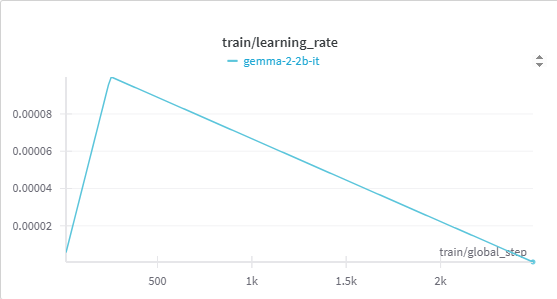

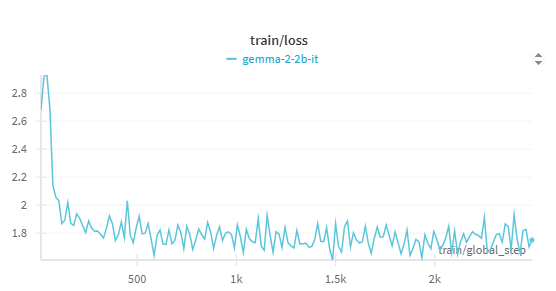

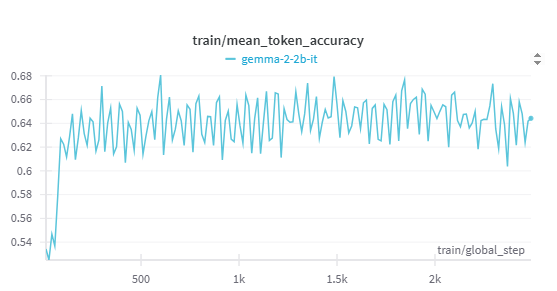

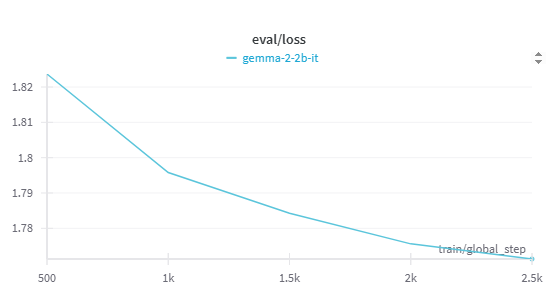

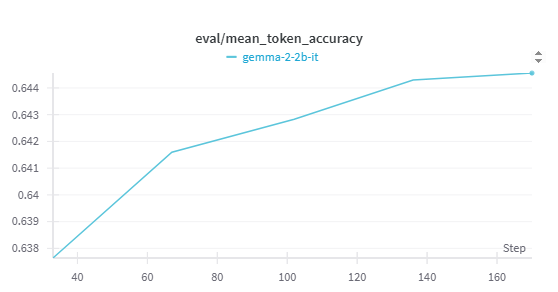

# Evaluation

In [ ]:
ft_metrics, ft_preds = evaluate_model(model, tokenizer, test_ds)
print("Zero-shot ROUGE:", zs_metrics)
print("ROUGE after fine-tuning:", ft_metrics)
print("Predictions after fine-tuning:")
for i, pred in enumerate(ft_preds[:10]):
    print(f"PREDICTION {i+1}")
    print(pred)
    print()

100%|██████████| 10/10 [02:01<00:00, 12.12s/it]

Zero-shot ROUGE: {'rouge1': 0.10119212690176677, 'rouge2': 0.00786056049213944, 'rougeL': 0.0713861070046592, 'rougeLsum': 0.08549798623903432}
ROUGE after fine-tuning: {'rouge1': 0.2274770269128608, 'rouge2': 0.08550610585978849, 'rougeL': 0.20110546598893286, 'rougeLsum': 0.19363185660684507}
Predictions after fine-tuning:
PREDICTION 1
#Person1# and #Person2# are watching a program about islam. #Person2# tells #Person1# about the pilgrimage to mecca. #Person2# tells #Person1# that the pilgrims must walk around a large, sacred black stone. #Person2# thinks that people believe they will be healed and that faith causes a change in their mind that cures them. #Person1# thinks that place is magical in any way.
#Person1# and #Person

PREDICTION 2
#Person1# wants to send a package by first-class mail and gets some stamps. #Person2# tells #Person1# where to get money orders. #Person1# is satisfied.
#Person1# wants to send a package by first-class mail and gets some stamps. #Person2# tells #P